# Detecção de objetos com YOLOv8n (Colab)

Notebook para treinar e validar o **YOLOv8n** no Google Colab e exportar artefatos mínimos para uma API **(sem necessidade de retornar bbox)**.

## Objetivo

- Treinar/fazer fine-tuning do **YOLOv8n** no **COCO completo (2017)** (`coco.yaml`).
- Validar com métricas padrão de detecção (**mAP50-95**, **mAP50**, **precision**, **recall**).
- Testar inferência com:
  - imagem da internet
  - upload de imagem no Colab
- Exportar apenas o necessário para criar a API depois:
  - `best.pt` (pesos)
  - `labels.json` (classes)
  - `config.json` (parâmetros de inferência)
  - `val_metrics.json` (métricas salvas)

> Observação: o modelo sempre calcula bbox internamente (NMS), mas sua API pode retornar só `label` + `confidence`.

## Instalação

Instala Ultralytics (YOLOv8) e dependências básicas para treino/validação e testes.

In [ ]:
!pip -q install -U ultralytics opencv-python matplotlib "pillow<12"
!pip -q install -U --force-reinstall "pillow<12"

In [ ]:
import json
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

from ultralytics import YOLO

# Project directory (tries to save in repo if it exists at runtime)
DEFAULT_PROJECT_DIR = Path("/content/tf-rn")
PROJECT_DIR = DEFAULT_PROJECT_DIR if DEFAULT_PROJECT_DIR.exists() else Path("/content")

ARTIFACT_DIR = PROJECT_DIR / "object-detection-api" / "object-detection-model" / "yolov8n"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("ARTIFACT_DIR:", ARTIFACT_DIR)

SEED = 42
np.random.seed(SEED)

PROJECT_DIR: /content
ARTIFACT_DIR: /content/object-detection-api/object-detection-model/yolov8n


## Treinamento (fine-tuning) no COCO completo

Aqui usamos o **COCO 2017 completo** (`coco.yaml`). Isso é **grande** (dezenas de GB) e pode levar horas para treinar.

Para facilitar, o notebook tem dois modos:
- **`TRAIN_MODE = "fast"`**: treina mais rápido (subset do COCO + `imgsz` menor) para validar o pipeline.
- **`TRAIN_MODE = "full"`**: treino completo (lento).

> Otimização importante: para acelerar, **desativamos validação a cada época** e fazemos a validação na seção dedicada (mantida no notebook).

## Preparar dataset (COCO 2017 completo) — download + validação

O **COCO completo** é grande. Esta seção:

- define `datasets_dir` para `/content/datasets` (você pode mudar para o Drive)
- tenta **baixar o COCO** automaticamente se não estiver presente
- valida paths de `train/val` e **falha explicitamente** se estiver faltando algo

> Dica: para evitar falta de espaço, use Drive:
> - `DATASETS_DIR = Path('/content/drive/MyDrive/datasets')`

In [ ]:
# experiment configuration (COCO)

MODEL_BASE = "yolov8n.pt"   # pre-trained COCO
DATASET_YAML = "coco.yaml" # COCO 2017 complete

# ---- training mode ----
# fast: runs much faster (subset + smaller imgsz)
# full: full training (much slower)
TRAIN_MODE = "fast"  # "fast" | "full"

# Important for performance: avoid validation every epoch
# (we keep the validation section separate in the notebook)
VAL_DURING_TRAIN = False

# Batch: use -1 for auto (recommended on Colab)
BATCH = -1

# CPU workers for DataLoader
WORKERS = 8

# Device
DEVICE = 0  # 0 for GPU; use "cpu" if needed

# Early stopping
PATIENCE = 50

# Augmentations (disable mosaic to speed up; in full, keep)
CLOSE_MOSAIC = 10

# Dataset subsampling (fraction of train)
FRACTION = 1.0

# Resolution/epochs
EPOCHS = 100
IMGSZ = 640

# Mode adjustments
if TRAIN_MODE == "fast":
    # Runs MUCH faster (good for validating pipeline and generating a fast best.pt)
    FRACTION = 0.20
    EPOCHS = 20
    IMGSZ = 512
    CLOSE_MOSAIC = 0
elif TRAIN_MODE == "full":
    FRACTION = 1.0
    EPOCHS = 100
    IMGSZ = 640
    CLOSE_MOSAIC = 10
else:
    raise ValueError("TRAIN_MODE inválido. Use 'fast' ou 'full'.")

# Inference/validation (API returns only label+confidence)
CONF = 0.25
IOU = 0.5
MAX_DET = 100

print("MODEL_BASE:", MODEL_BASE)
print("DATASET_YAML:", DATASET_YAML)
print("TRAIN_MODE:", TRAIN_MODE)
print("EPOCHS:", EPOCHS, "IMGSZ:", IMGSZ, "BATCH:", BATCH, "FRACTION:", FRACTION)
print("VAL_DURING_TRAIN:", VAL_DURING_TRAIN)

Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

In [ ]:
from pathlib import Path
import os

# (Optional) If you want to use Drive to store the COCO (recommended):
# from google.colab import drive
# drive.mount('/content/drive')
# DATASETS_DIR = Path('/content/drive/MyDrive/datasets')

DATASETS_DIR = Path("/content/datasets")
DATASETS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Fix the Ultralytics datasets directory
try:
    from ultralytics import settings as yolo_settings  # type: ignore

    yolo_settings.update({"datasets_dir": str(DATASETS_DIR)})
    print("Ultralytics datasets_dir:", yolo_settings.get("datasets_dir"))
except Exception:
    print("Não consegui atualizar settings via API; seguindo com settings padrão.")

# 2) Download the COCO only if it doesn't exist (avoids slow re-check/download every time)
# Typical layout after download: /content/datasets/coco/images/train2017
coco_root = DATASETS_DIR / "coco"
train2017 = coco_root / "images" / "train2017"
val2017 = coco_root / "images" / "val2017"

AUTO_DOWNLOAD_COCO = True

if AUTO_DOWNLOAD_COCO and (not train2017.exists() or not val2017.exists()):
    print("COCO não encontrado. Iniciando download (pode demorar bastante)...")
    os.system("yolo datasets download coco")
else:
    print("COCO já existe. Pulando download.")

# 3) Validate dataset via Ultralytics
from ultralytics.data.utils import check_det_dataset

DATA_INFO = check_det_dataset(DATASET_YAML)
print("Dataset carregado:")
print({k: DATA_INFO.get(k) for k in ["path", "train", "val"] if k in DATA_INFO})

train_path = Path(str(DATA_INFO["train"]))
val_path = Path(str(DATA_INFO["val"]))

if not train_path.exists() or not val_path.exists():
    raise FileNotFoundError(
        "COCO não está pronto.\n"
        f"train: {train_path} (exists={train_path.exists()})\n"
        f"val:   {val_path} (exists={val_path.exists()})\n\n"
        "Dica: verifique espaço em disco/Drive e rode novamente: !yolo datasets download coco"
    )

print("OK. Dataset pronto:")
print("- train:", train_path)
print("- val:", val_path)

# 4) Train (time optimizations)
model = YOLO(MODEL_BASE)
results = model.train(
    data=DATASET_YAML,
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=DEVICE,
    workers=WORKERS,
    patience=PATIENCE,
    close_mosaic=CLOSE_MOSAIC,
    fraction=FRACTION,
    val=VAL_DURING_TRAIN,
    project=str(ARTIFACT_DIR),
    name="train",
    exist_ok=True,
    seed=SEED,
)

print("Treino finalizado. Pasta:", ARTIFACT_DIR / "train")

Ultralytics datasets_dir: /content/datasets
Dataset carregado:
{'path': PosixPath('/content/datasets/coco128'), 'train': '/content/datasets/coco128/images/train2017', 'val': '/content/datasets/coco128/images/train2017', 'names': {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot do

## Validação (métricas SOTA)

Relata métricas padrão de detecção: **mAP50-95**, **mAP50**, **precision**, **recall**.

> Mesmo que sua API não retorne bbox, a detecção usa bbox internamente (NMS). A resposta da API pode retornar apenas `label` e `confidence`.

In [ ]:
# Use best.pt for validation
best_pt = ARTIFACT_DIR / "train" / "weights" / "best.pt"
assert best_pt.exists(), f"Não encontrei {best_pt}. Verifique o treino."

best_model = YOLO(str(best_pt))

val_metrics = best_model.val(data=DATASET_YAML, imgsz=IMGSZ)

# Ultralytics returns an object with many fields; we print what normally matters
summary = {
    "mAP50-95": float(getattr(val_metrics.box, "map", 0.0)),
    "mAP50": float(getattr(val_metrics.box, "map50", 0.0)),
    "mAP75": float(getattr(val_metrics.box, "map75", 0.0)),
    "precision": float(getattr(val_metrics.box, "mp", 0.0)),
    "recall": float(getattr(val_metrics.box, "mr", 0.0)),
    "imgsz": int(IMGSZ),
    "dataset": DATASET_YAML,
}

print(json.dumps(summary, indent=2))

(ARTIFACT_DIR / "val_metrics.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
print("Salvo:", ARTIFACT_DIR / "val_metrics.json")

Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1605.6±125.9 MB/s, size: 40.3 KB)
val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 41.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.6it/s 4.9s
                   all        128        929      0.634      0.604      0.656      0.491
                person         61        254       0.75      0.701      0.774      0.551
               bicycle          3          6      0.609      0.333      0.388      0.306
                   car         12         46      0.625      0.217      0.286      0.187
            motorcycle          4          5      0.642        0.8       0.92      0.719
              airplane          5       

## Inferência (imagem da internet)

Baixa uma imagem por URL e retorna **apenas as classes/confidências** (sem bbox), além de mostrar a visualização opcional.

Arquivo: /content/object-detection-api/object-detection-model/yolov8n/internet_image.jpg
Qtd objetos: 6
[
  {
    "label": "person",
    "confidence": 0.9351933002471924
  },
  {
    "label": "traffic light",
    "confidence": 0.8310363292694092
  },
  {
    "label": "bus",
    "confidence": 0.6509943604469299
  },
  {
    "label": "traffic light",
    "confidence": 0.44934991002082825
  },
  {
    "label": "truck",
    "confidence": 0.4449552595615387
  },
  {
    "label": "traffic light",
    "confidence": 0.43026888370513916
  }
]


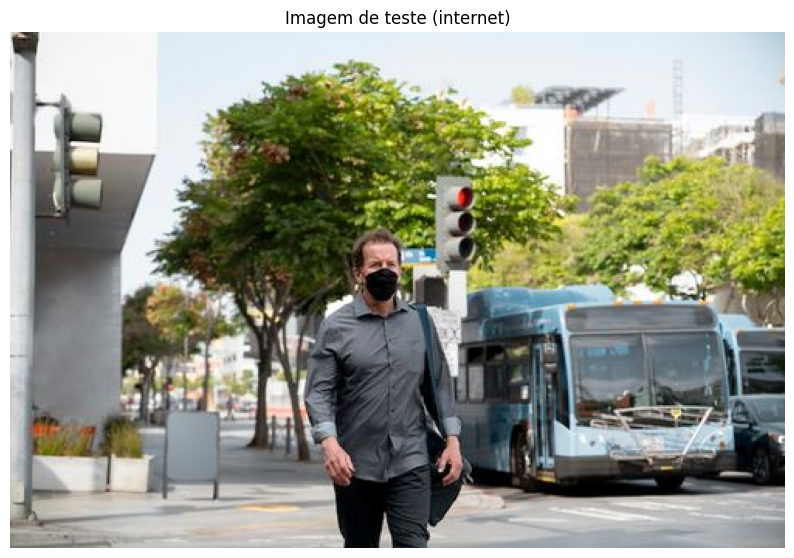

In [ ]:
import urllib.request

IMAGE_URL = "https://imgs.search.brave.com/kWtLzGCusm1oCrmmD1J_EvYoWJJi4NXL51QxRrZDo3A/rs:fit:500:0:1:0/g:ce/aHR0cHM6Ly9pbWcu/ZnJlZXBpay5jb20v/Zm90b3MtZ3JhdGlz/L3Byb3RlY2FvLWRl/LW1hc2NhcmEtZmFj/aWFsLW5hLXZpZGEt/ZGlhcmlhXzIzLTIx/NDkwOTY4MTAuanBn/P3NlbXQ9YWlzX2h5/YnJpZCZ3PTc0MCZx/PTgw"  # public example image
img_path = ARTIFACT_DIR / "internet_image.jpg"
urllib.request.urlretrieve(IMAGE_URL, img_path)

pred = best_model.predict(source=str(img_path), imgsz=IMGSZ, conf=CONF, iou=IOU, max_det=MAX_DET, verbose=False)[0]

names = pred.names
boxes = pred.boxes

objects = []
for b in boxes:
    cls_id = int(b.cls.item())
    conf = float(b.conf.item())
    objects.append({"label": names[cls_id], "confidence": conf})

# Sort by confidence
objects = sorted(objects, key=lambda x: x["confidence"], reverse=True)

print("Arquivo:", str(img_path))
print("Qtd objetos:", len(objects))
print(json.dumps(objects[:25], indent=2))  # top 25

# Optional: Visualization (with bbox only for inspection in the notebook)
img_vis = Image.open(img_path)
plt.figure(figsize=(10, 7))
plt.imshow(np.asarray(img_vis))
plt.axis('off')
plt.title("Imagem de teste (internet)")
plt.show()

# If you want to visualize with bbox (only for debugging):
# im_annot = pred.plot()  # numpy
# plt.figure(figsize=(10,7)); plt.imshow(im_annot); plt.axis('off'); plt.show()

## Inferência (upload de imagem no Colab)

Faz upload de uma imagem local e retorna somente `label` + `confidence`.

In [ ]:
try:
    from google.colab import files  # type: ignore
except Exception as e:
    raise RuntimeError("Este bloco é específico do Google Colab.") from e

uploaded = files.upload()
if not uploaded:
    raise ValueError("Nenhum arquivo enviado.")

uploaded_name = next(iter(uploaded.keys()))
uploaded_path = Path(uploaded_name)

pred = best_model.predict(source=str(uploaded_path), imgsz=IMGSZ, conf=CONF, iou=IOU, max_det=MAX_DET, verbose=False)[0]

names = pred.names
objects = []
for b in pred.boxes:
    cls_id = int(b.cls.item())
    conf = float(b.conf.item())
    objects.append({"label": names[cls_id], "confidence": conf})

objects = sorted(objects, key=lambda x: x["confidence"], reverse=True)

print("Arquivo:", str(uploaded_path))
print("Qtd objetos:", len(objects))
print(json.dumps(objects[:25], indent=2))

# Visualização opcional
img_vis = Image.open(uploaded_path).convert('RGB')
plt.figure(figsize=(10, 7))
plt.imshow(np.asarray(img_vis))
plt.axis('off')
plt.title("Imagem de teste (upload)")
plt.show()

# Debug com bbox:
# im_annot = pred.plot(); plt.figure(figsize=(10,7)); plt.imshow(im_annot); plt.axis('off'); plt.show()

## Export de artefatos para futura API (somente pesos + classes)

Exporta apenas o necessário para a API:

- `best.pt`
- `labels.json`
- `config.json`

> Mantemos o restante dentro de `train/` (logs, resultados do treino, etc.).

In [ ]:
import shutil

# Copy best.pt to the root of the artifact dir
best_pt_out = ARTIFACT_DIR / "best.pt"
shutil.copyfile(best_pt, best_pt_out)
print("Copiado:", best_pt_out)

# Labels (class COCO)
labels = {"classes": [best_model.names[i] for i in range(len(best_model.names))]}
(ARTIFACT_DIR / "labels.json").write_text(json.dumps(labels, indent=2), encoding="utf-8")
print("Salvo:", ARTIFACT_DIR / "labels.json")

# Minimal config for the API (return only label+confidence)
config = {
    "model": "yolov8n",
    "weights_pt": "best.pt",
    "imgsz": int(IMGSZ),
    "conf": float(CONF),
    "iou": float(IOU),
    "max_det": int(MAX_DET),
    "return_bboxes": False,
}
(ARTIFACT_DIR / "config.json").write_text(json.dumps(config, indent=2), encoding="utf-8")
print("Salvo:", ARTIFACT_DIR / "config.json")

print("Artefatos em:", ARTIFACT_DIR)
for p in sorted(ARTIFACT_DIR.glob("*")):
    print("-", p.name)

print("\nObs: logs/resultados do treino ficam em:", ARTIFACT_DIR / "train")


Copiado: /content/object-detection-api/object-detection-model/yolov8n/best.pt
Ultralytics 8.4.4 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/object-detection-api/object-detection-model/yolov8n/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 14 packages in 221ms
Prepared 3 packages in 5.32s
Installed 3 packages in 74ms
 + colorama==0.4.6
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.82

requirements: AutoUpdate success ✅ 6.0s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.20.1 opset 22...


/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.82...
ONNX: export success ✅ 7.8s, saved as '/content/object-detection-api/object-detection-model/yolov8n/train/weights/best.onnx' (12.3 MB)

Export complete (8.2s)
Results saved to /content/object-detection-api/object-detection-model/yolov8n/train/weights
Predict:         yolo predict task=detect model=/content/object-detection-api/object-detection-model/yolov8n/train/weights/best.onnx imgsz=640 
Validate:        yolo val task=detect model=/content/object-detection-api/object-detection-model/yolov8n/train/weights/best.onnx imgsz=640 data=/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/datasets/coco128.yaml  
Visualize:       https://netron.app
Exportado: /content/object-detection-api/object-detection-model/yolov8n/best.onnx
Artefatos em: /content/object-detection-api/object-detection-model/yolov8n
- best.onnx
- best.pt
- config.json
- export
- inference.py
- internet_image.jpg
- labels.json
- requirements_api.txt
- train
- val_metrics.json
